# CESM Cleaning and Exploratory Data Analysis
Using our `pip`-installable `cesm` package, we perform a variety of cleaning and transformation procedures. These functions are written to be performed on all datasets at once, creating a dictionary of datasets.

## CESM Scenario Overview
**historical:** CMIP data from 1850-2014

_The remainder are SSP-based RCP scenarios with variable radiative forcing by the end of the century. These forcings, called "Representative Concentration Pathways", are concentration-driven and follow variable socioeconomic conditions. The numbers after "RCP" signify a specific level of radiative forcing reached in the year 2100, in terms of Watts per meter squared. (e.g., RCP4.5 represents $4.5 \frac{W}{m^{2}}$ of forcing in 2100)._ 

**ssp126:**  Low forcing, following approximately RCP2.6 global forcing pathway with SSP1 socioeconomic conditions.

**ssp245:**  Medium forcing, following approximately RCP4.5 global forcing pathway with SSP2 socioeconomic conditions.

**ssp370:**  Medium-high forcing, following approximately RCP7.0 global forcing pathway with SSP3 socioeconomic conditions.

**ssp585:**  High forcing, following approximately RCP8.5 global forcing pathway with SSP5 socioeconomic conditions.

## CESM Variable Definitions
[Link to full list of CMIP variables](https://clipc-services.ceda.ac.uk/dreq/index/var.html)

**huss:** Near-Surface Specific Humidity

**hurs:** Near-Surface Relative Humidity \[%\]

**pr:** Precipitation $[\frac{kg}{m^{2}s}]$

**tas:** Near-Surface Air Temperature \[K\]

**tasmin:** Daily Minimum Near-Surface Air Temperature \[K\]

**tasmax:** Daily Maximum Near-Surface Air Temperature \[K\]

In [1]:
import os
import shelve

import xarray as xr
import numpy as np

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

## After pip install,
from cesm import cesm_analyze as ca
from cesm import cesm_viz as cv
from cesm import cesm_summarize as cs

In [2]:
# Declare global variables
crs = ccrs.PlateCarree()  # set projection

vardict = {
    'huss': {'name': 'Specific Humidity', 'units': ''},
    'hurs': {'name': 'Relative Humidity', 'units': '[%]'},
    'pr': {'name': r'Precipitation', 'units': '$[\frac{kg}{m^{2}s}]$'},
    'tas': {'name': 'Air Temperature', 'units': '[K]'},
    'tasmin': {'name': 'Daily Min. Air Temperature', 'units': '[K]'},
    'tasmax': {'name': 'Daily Max. Air Temperature', 'units': '[K]'},
}

modeldict = {
    'hist': {
        'code': 'historical', 'name': 'Historical Data'
    },
    'sp1': {
        'code': 'ssp126', 'name': r'$Scenario \#1: 2.6 \frac{W}{m^{2}}$'
    },
    'sp2': {
        'code': 'ssp245', 'name': r'$Scenario \#2: 4.5 \frac{W}{m^{2}}$'
    },
    'sp3': {
        'code': 'ssp370', 'name': r'$Scenario \#3: 7.0 \frac{W}{m^{2}}$'
    },
    'sp5': {
        'code': 'ssp585', 'name': r'$Scenario \#5: 8.5 \frac{W}{m^{2}}$'
    },
}


list(modeldict)

['hist', 'sp1', 'sp2', 'sp3', 'sp5']

In [3]:
# Save dicts to analysis folder for use in other notebooks
path_dicts = '../analysis_data/descriptors.bak'

if not os.path.exists(path_dicts):
    print('Saving dictionaries as binary shelve')
    
    with shelve.open('../analysis_data/descriptors') as db:
        db['vardict'] = vardict
        db['modeldict'] = modeldict

The `modeldict` keys are the available CESM datasets. Let's read them into memory and assess their structure.

## Data import

In [4]:
ds = ca.dictorize(
    func = xr.open_zarr, 
    modeldict = {k: v['code'] for k, v in modeldict.items()},
)

print(f'Available datasets: {list(ds)}')
ds['hist']

Available datasets: ['hist', 'sp1', 'sp2', 'sp3', 'sp5']


<xarray.Dataset>
Dimensions:    (time: 1980, lat: 192, lon: 288, nbnd: 2)
Coordinates:
  * lat        (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 88.12 89.06 90.0
    lat_bnds   (lat, nbnd) float64 dask.array<chunksize=(192, 2), meta=np.ndarray>
  * lon        (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
    lon_bnds   (lon, nbnd) float64 dask.array<chunksize=(288, 2), meta=np.ndarray>
  * time       (time) object 1850-01-15 12:00:00 ... 2014-12-15 12:00:00
    time_bnds  (time, nbnd) object dask.array<chunksize=(1980, 2), meta=np.ndarray>
Dimensions without coordinates: nbnd
Data variables:
    hurs       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    huss       (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    pr         (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
    tas        (time, lat, lon) float32 dask.array<chunksize=(600, 192, 288), meta=np.ndarray>
Attributes: (12/49)
    Conventions:            CF-1.7 CMIP-6.2
    activity_id:            CMIP
    branch_method:          standard
    branch_time_in_child:   674885.0
    branch_time_in_parent:  219000.0
    case_id:                972
    ...                     ...
    table_id:               Amon
    tracking_id:            hdl:21.14100/56114e92-8200-4e9f-b9d0-48580aeb8395...
    variable_id:            hurs
    variant_info:           CMIP6 20th century experiments (1850-2014) with C...
    variant_label:          r11i1p1f1
    version_id:             v20190514

Each dataset has dimensions of `lat`, `lon`, and `time`. They all contain variables of `hurs`, `huss`, `pr`, and `tas`. All datasets except the historical data contain two additional variables: `tasmin` and `tasmax`.

Each dataset has dimensions of `lat`, `lon`, and `time`. They all contain variables of `hurs`, `huss`, `pr`, and `tas`. All datasets except the historical data contain two additional variables: `tasmin` and `tasmax`.

## Weights

To conduct spatial averages, we need to weight the data according to the curvature of the Earth (so that polar regions do not provide outsized influence). This can be done with a bounded cosine wave. 

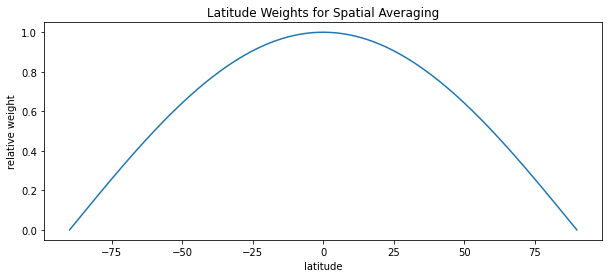

In [5]:
# Perform weighing to get true aggregate statistics

# First, an example of weights by Earth's latitude
weights = np.cos(np.deg2rad(ds['hist']['lat']))
weights.name = 'weights'


# Save dicts to analysis folder for use in other notebooks
path_weight_arr = '../analysis_data/weights.npy'

if not os.path.exists(path_weight_arr):
    print('Saving weights as binary .npy')
    
    np.save(path_weight_arr, weights)


########################################################
# Plot weights
path_weights = '../figures/weights.png'

cv.plot_lines(
    data = weights, 
    path = path_weights, 
    xlab = 'latitude', 
    ylab = 'relative weight', 
    title = 'Latitude Weights for Spatial Averaging'
)

In [6]:
# Perform weighing on all datasets
ds_w = ca.dictorize(
    func = 'weight', 
    modeldict = ds,
)

ds_w['hist']

DatasetWeighted with weights along dimensions: lat

## Air Temperature Timelines

Now, let's first look at historical annual averages of air temperature.

In [7]:
# Look at global averages
# "_mt" for mean data at each time step (month)
ds_mt = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_w,
         # in aggs, roll arg is required below (even if empty)
        {'grps': ('lat', 'lon'), 'aggfunc': np.nanmean, 'roll': {}},
    ),
)


# "_my" for mean of each year
ds_my = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        ds_mt,
         # in aggs, roll arg is required below (even if empty)
        {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
    ),
)

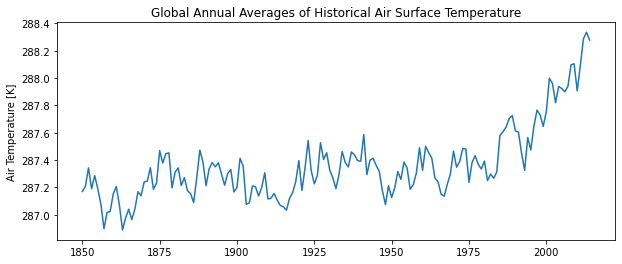

In [8]:
# Plot historical global average surface air temperature
path_htt = '../figures/hist_temp_timeline.png'

var = 'tas'
var_name = vardict[var]['name']
var_units = vardict[var]['units']
var_lab = f'{var_name} {var_units}'

########################################################
# Plot weights
path_htt = '../figures/hist_temp_timeline.png'

cv.plot_lines(
    data = ds_my['hist'][var], 
    path = path_htt, 
    xlab = '', 
    ylab = var_lab, 
    title = 'Global Annual Averages of Historical Air Surface Temperature'
)

So 1850 - ~1980 may be more appropriate for historical average comparisons.

Now, let's look at past vs. future for air temperatures!

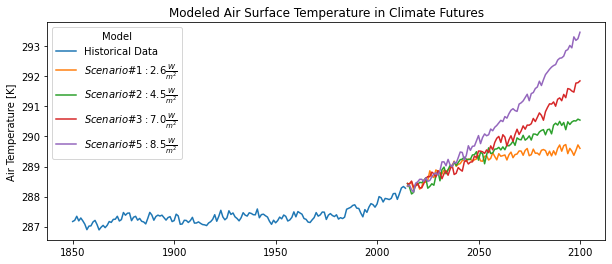

In [9]:
# Plot annual averages of historical/and future scenario air temperatures

path_att = '../figures/all_temp_timeline.png'

cv.plot_lines(
    data = ds_my,
    var = var,
    path = path_att, 
    xlab = '', 
    ylab = var_lab,
    varlabs = modeldict,
    title = 'Modeled Air Surface Temperature in Climate Futures'
)

## Calculate baseline

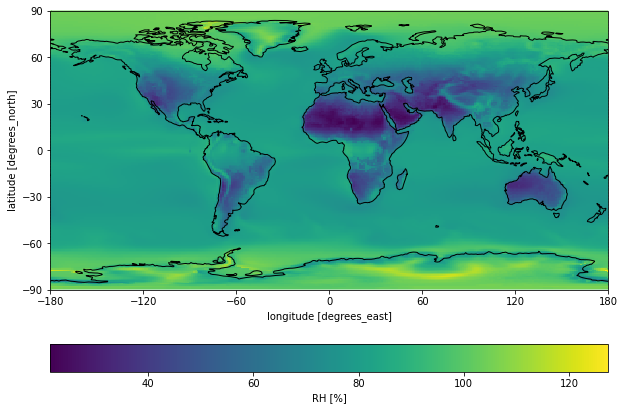

In [10]:
# Calculate baselines from subset of raw data
baseline = (
    ds['hist']
    .sel(time=slice('1850', '1980'))
    .mean('time')
)

########################################################
# Plot baseline RH
cv.plot_map(
    baseline,
    'hurs',
    crs,
    varlab='RH [%]',
    title='Historical Baseline of Relative Humidity',
    path='../figures/baseline_rh.png',
)

## Compare models to baseline

In [11]:
# Create differences between models and historical data 

# First, get copies of historical and scenario data
ds_diffs = ds.copy()
ds_diffs['hist'] = baseline.copy()

# Then calculate differences between models and baseline
ds_diffs = ca.dictorize(
    func = 'diff',
    modeldict = ca.nest_dicts(
        ds_diffs,
    ),
)

print(ds_diffs.keys())
ds_diffs['sp3']

dict_keys(['sp1', 'sp2', 'sp3', 'sp5'])


<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, time: 1032)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * time     (time) object 2015-01-15 12:00:00 ... 2100-12-15 12:00:00
Data variables:
    hurs     (time, lat, lon) float32 dask.array<chunksize=(347, 192, 288), meta=np.ndarray>
    huss     (time, lat, lon) float32 dask.array<chunksize=(325, 192, 288), meta=np.ndarray>
    pr       (time, lat, lon) float32 dask.array<chunksize=(288, 192, 288), meta=np.ndarray>
    tas      (time, lat, lon) float32 dask.array<chunksize=(408, 192, 288), meta=np.ndarray>

Let's look at the estimated change in air temperature in the year 2100.

In [12]:
# Select all difference data for the year 2100 
d_finalyr = ca.dictorize(
    func = 'sel',
    modeldict = ca.nest_dicts(
        ds_diffs,
        {'args': {'time': '2100'}},
    ),
)

# Calculate an annual average for each lat/lon cell
diff_mns = ca.dictorize(
    func = 'agg',
    modeldict = ca.nest_dicts(
        d_finalyr,
        {'grps': 'time.year', 'aggfunc': np.nanmean, 'roll': {}},
    ),
)

diff_mns['sp2']

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, year: 1)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * year     (year) int64 2100
Data variables:
    hurs     (year, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    huss     (year, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    pr       (year, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>
    tas      (year, lat, lon) float32 dask.array<chunksize=(1, 192, 288), meta=np.ndarray>

In [13]:
# Store progress to disk
for model in list(diff_mns):
    fpath = f'../analysis_data/{model}_bsub_2100.zarr'

    if not os.path.exists(fpath):
        print(f'Writing background-subtracted {model} to disk...') 
        diff_mns[model].to_zarr(fpath)
    
###########################################################################
with shelve.open('../analysis_data/descriptors') as db:
    vardict = db['vardict']
    modeldict = db['modeldict']

crs = ccrs.PlateCarree()  # set projection

diff_mns = {}

for model in list(modeldict):
    if model != 'hist':
        diff_mns[model] = xr.open_zarr(
            f'../analysis_data/{model}_bsub_2100.zarr', 
        )


Now, convert from dictionaries to single dataset for faceted analysis.

In [14]:
dfa = ca.facet_ds(diff_mns, 'tas')
dfa

<xarray.Dataset>
Dimensions:  (lat: 192, lon: 288, model: 4)
Coordinates:
  * lat      (lat) float64 -90.0 -89.06 -88.12 -87.17 ... 87.17 88.12 89.06 90.0
  * lon      (lon) float64 0.0 1.25 2.5 3.75 5.0 ... 355.0 356.2 357.5 358.8
  * model    (model) <U3 'sp1' 'sp2' 'sp3' 'sp5'
Data variables:
    tas      (lat, lon, model) float32 3.013 5.958 8.046 ... 8.761 11.09 14.71

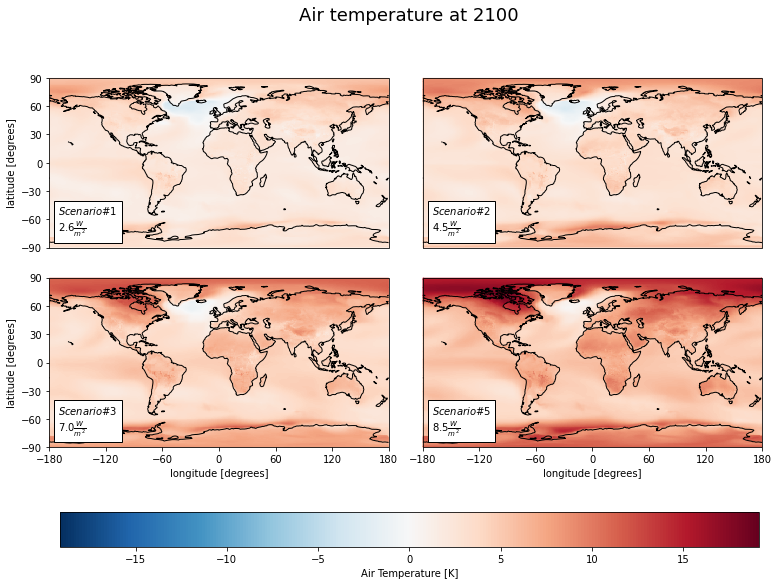

In [15]:
cv.plot_facetmap(
    dfa, 'tas', 
    crs, vardict, modeldict, 
    title='Air temperature at 2100',
    path = "../figures/ww_tas.png",
)

In [16]:
ww_tas_sum = cs.average_and_max(diff_mns, 'tas')
ww_tas_sum.to_csv('../analysis_data/ww_tas.csv') 
ww_tas_sum

,sp1,sp2,sp3,sp5
Mean,2.697534,3.893385,5.407121,7.411402
Max,8.297601,10.178103,12.911526,19.133661


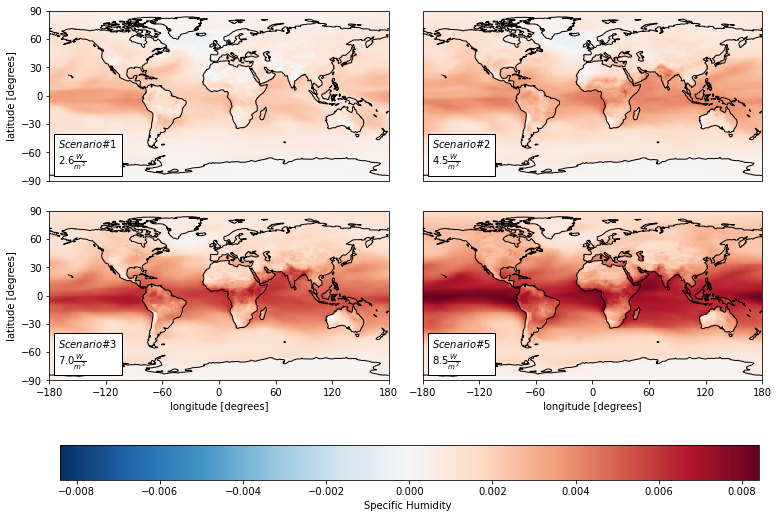

In [17]:
dfb = ca.facet_ds(diff_mns, 'huss')

cv.plot_facetmap(
    dfb, 'huss', 
    crs, vardict, modeldict, 
    savefig=False, path = "../figures/ww_huss.png"
)

In [18]:
ww_huss_sum = cs.average_and_max(diff_mns, 'huss')
ww_huss_sum.to_csv('../analysis_data/ww_huss.csv') 
ww_huss_sum

,sp1,sp2,sp3,sp5
Mean,0.001088,0.001619,0.00233,0.0032
Max,0.003957,0.005402,0.007174,0.008397


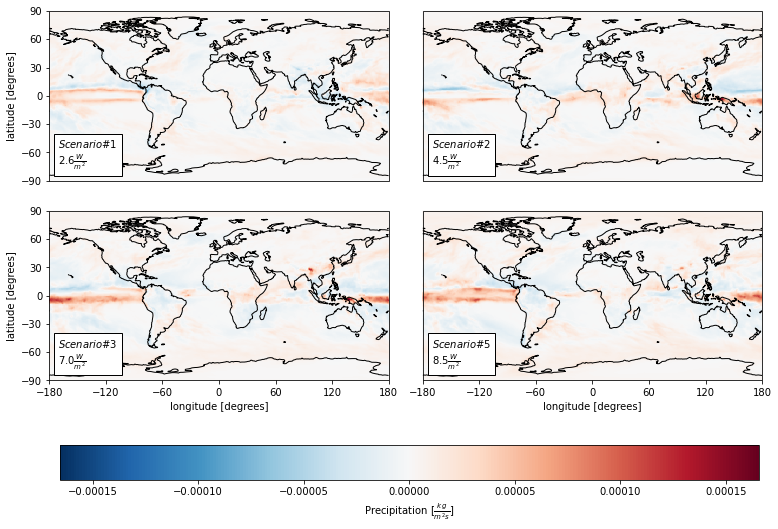

In [19]:
vardict['pr']['units'] = r'$[\frac{kg}{m^{2}s}]$'
dfc = ca.facet_ds(diff_mns, 'pr')

cv.plot_facetmap(
    dfc, 'pr', 
    crs, vardict, modeldict, 
    savefig=False, path = "../figures/ww_pr.png"
)

In [20]:
ww_pr_sum = cs.average_and_max(diff_mns, 'pr')
ww_pr_sum.to_csv('../analysis_data/ww_pr.csv') 
ww_pr_sum

,sp1,sp2,sp3,sp5
Mean,0.000002,0.000002,0.000003,0.000004
Max,0.000061,0.000165,0.000163,0.000127
